<a href="https://colab.research.google.com/github/damzC/ml-demos/blob/master/Football_Match_Outcome_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Football Match Outcome Prediction

This notebook covers the prediction of football match outcomes. The key steps are as follows:

1.   Extracting the **data** for train and test
2.   **Analyse** the data from the following perspectives:
  1.   Address *missing values* in the data - Makes the prediction models robust
  2.   Understand **distribution** and **bias** in the dataset
  3.   Feature Selection:
        1.   **F-statistic** and statistical significance using **p-value**
        2.   **Chi-square** test to identify feature association and dependency
        3.   Investigate **multicollinearity** in the data
        4.   Understand feature **correlation**
        5.   Finally a *list of relevant features* is created based on the data analysis
3.   **Data Preparation** for Training, Validation, and Testing
4.   **Model Training**:
  1.   Multiple prediction models are trained for comparison
  2.   Optimal parameters are estimated using **Grid Search**
  3.   Two (2) sets of models are trained:
        1.   Using all features
        2.   Using only relevant features
  4.   Train the following prediction models:
        1.   Logistic Regression
        2.   Support Vector Machine (SVM)
        3.   Bagging - Random Forest
        4.   Boosting - eXtreme Gradient BOOSTing (XGBOOST)
5.   **Evaluate** the trained models on **validation** set:
        1.   Using all features
        2.   Using only relevant features
        3.   Find the best model
6.   Evaluate the **predictions** of the trained models on the **test** set        
7.   **Appendix:**
  1.   **Explainability** of models  
  2.   **Data Augmentation** and **Incremental Learning**




# Import Packages

In [ ]:
# Utility packages
from os import path, makedirs, walk
import json
from time import time

# Packages for Data Analysis and Preparation
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2, f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Packages for training and evaluation of models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from joblib import dump, load

# Packages for plotting graphs and figures
import matplotlib.pyplot as plt
import seaborn as sns


# Remove warnings

In [ ]:
import warnings
warnings.filterwarnings("ignore")


# Dataset Extraction

Here we get train and test data from the dataset provided.

Next we convert the data from csv format to a pandas dataframe

In [ ]:
data_folder = 'data'
train_file = 'train.csv'
test_file = 'test-3.csv'

train_path = path.join(data_folder, train_file)
test_path = path.join(data_folder, test_file)

train_df = pd.read_csv(train_path)
train_df.head()


AC    AF   AR    AS  AST   AY       AwayTeam      Date FTR    HC    HF  \
0   3.0  12.0  0.0  14.0  4.0  0.0      Stuttgart  07/08/09   H   6.0  12.0   
1   1.0  10.0  0.0   7.0  0.0  1.0        FC Koln  08/08/09   H  16.0   8.0   
2   3.0  20.0  0.0  15.0  3.0  2.0       Hannover  08/08/09   H   5.0  16.0   
3  10.0  28.0  0.0   9.0  3.0  2.0  Bayern Munich  08/08/09   D   3.0  10.0   
4   5.0  28.0  0.0  13.0  7.0  2.0     Leverkusen  08/08/09   D   3.0  22.0   

    HR    HS   HST  HTAG  HTHG   HY    HomeTeam      league  
0  0.0  13.0   7.0   0.0   0.0  0.0   Wolfsburg  bundesliga  
1  0.0  24.0  11.0   0.0   0.0  0.0    Dortmund  bundesliga  
2  0.0  10.0   4.0   0.0   0.0  3.0      Hertha  bundesliga  
3  0.0   9.0   1.0   1.0   1.0  0.0  Hoffenheim  bundesliga  
4  0.0   8.0   4.0   2.0   1.0  1.0       Mainz  bundesliga

# Data Insights and Analysis


The features of the dataset and their details are as follows:

*   **HomeTeam** - Home Team
*   **AwayTeam** - Away Team
*   **FTR** - Full-Time Result (H=Home Win, D=Draw, A=Away Win)
*   **HTHG** - Half Time Home Team Goals
*   **HTAG** - Half Time Away Team Goals
*   **HS** - Home Team Shots
*   **AS** - Away Team Shots
*   **HST** - Home Team Shots on Target
*   **AST** - Away Team Shots on Target
*   **AC** - Away Team Corners
*   **HF** - Home Team Fouls Committed
*   **AF** - Away Team Fouls Committed
*   **HC** - Home Team Corners
*   **HY** - Home Team Yellow Cards
*   **AY** - Away Team Yellow Cards
*   **HR** - Home Team Red Cards
*   **AR** - Away Team Red Cards
*   **Date** - On which day the match was played
*   **league** - Under which league the match was played


---

As part of the data analysis we will do the following:
1. Investigate **missing values**:
    1. Find missing values in the data
    2. Replace/ remove null values
    3. This essentially makes it easier for the model to learn and makes it more robust
2. Investigate Data **Covariance**
3. Investigate Data **Collinearity**
4. Investigate **feature relevance**
5. Investigate bias

## Utility Functions for Data Analysis and Preparation

In [ ]:
# Function to get null columns in dataframe
def get_null_columns(df):
  """
  Returns a list of columns in the dataframe that have null values.
  """
  null_columns = []
  for column in df.columns:
    if df[column].isnull().any():
      null_columns.append(column)
  return null_columns

# Function to convert categorical features to numerical features
def convert_categorical_to_numerical(df):
  """
  Converts categorical features to numerical features using LabelEncoder.

  The FTR feature (dependant feature) is converted to float.
  FTR Float-value Mapping:
  H = 2.0
  D = 1.0
  A = 0.0

  """
  #Get categorical columns
  categorical_columns = df.select_dtypes(include=['object']).columns

  # Encode categorical columns using LabelEncoder
  le = LabelEncoder()
  for column in categorical_columns:
      df[column] = le.fit_transform(df[column])

  # Convert FTR to float
  if 'FTR' in df.columns:
    df['FTR'] = df['FTR'].astype(float)

  return df


## 1. Investigate missing values

#### Find features with null values

In [ ]:
# Extract number of samples for each column which have null values.
for column in get_null_columns(train_df):
  null_count = train_df[column].isnull().sum()
  print(f"Column: {column}, Null Value Count: {null_count}")


Column: AC, Null Value Count: 9
Column: AF, Null Value Count: 11
Column: AR, Null Value Count: 9
Column: AS, Null Value Count: 9
Column: AST, Null Value Count: 9
Column: AY, Null Value Count: 9
Column: AwayTeam, Null Value Count: 7
Column: Date, Null Value Count: 7
Column: FTR, Null Value Count: 7
Column: HC, Null Value Count: 9
Column: HF, Null Value Count: 11
Column: HR, Null Value Count: 9
Column: HS, Null Value Count: 9
Column: HST, Null Value Count: 9
Column: HTAG, Null Value Count: 10
Column: HTHG, Null Value Count: 10
Column: HY, Null Value Count: 10
Column: HomeTeam, Null Value Count: 7


#### Get data type for each feature

In [ ]:
data_types = train_df.dtypes
for column, dtype in data_types.items():
  print(f"Column: {column}, Data Type: {dtype}")


Column: AC, Data Type: float64
Column: AF, Data Type: float64
Column: AR, Data Type: float64
Column: AS, Data Type: float64
Column: AST, Data Type: float64
Column: AY, Data Type: float64
Column: AwayTeam, Data Type: object
Column: Date, Data Type: object
Column: FTR, Data Type: object
Column: HC, Data Type: float64
Column: HF, Data Type: float64
Column: HR, Data Type: float64
Column: HS, Data Type: float64
Column: HST, Data Type: float64
Column: HTAG, Data Type: float64
Column: HTHG, Data Type: float64
Column: HY, Data Type: float64
Column: HomeTeam, Data Type: object
Column: league, Data Type: object


**Missing value Insights**


*   Replacing the features '*Away Team*' and '*Home Team*' with missing values is not a logical replacement, as it leads to inaccuracy and bias in the data.
*   As the number of rows with null values for '*Away Team*' and '*Home Team*' are significantly less (7), we will remove these samples.
*   We will replace the remaining missing values of the data with mean/mode values












#### Remove samples with null values for 'Away Team' and 'Home Team'

In [ ]:
# Remove all rows with 'Away Team' and 'Home Team' columns as null

print(f"Number of samples before removing null values: {train_df.shape[0]}")
train_df = train_df.dropna(subset=['AwayTeam', 'HomeTeam'])
print(f"Number of samples after removing null values: {train_df.shape[0]}")


Number of samples before removing null values: 12789
Number of samples after removing null values: 12782


#### Replace null values with an optimal value (mean/ mode) for each column

In [ ]:
# Replace null values in numeric columns with the mean
numeric_columns = train_df.select_dtypes(include=['float', 'int']).columns
for column in numeric_columns:
    if train_df[column].isnull().any():
        train_df[column] = train_df[column].fillna(train_df[column].mean())

# Replace null values in categorical columns with the mode
categorical_columns = train_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if train_df[column].isnull().any():
        train_df[column] = train_df[column].fillna(train_df[column].mode()[0])

print(f"Columns with null values: {get_null_columns(train_df)}")

Columns with null values: []


## 2. Data Distribution Analysis (Data Bias Check)

##### League-wise Data Distribution

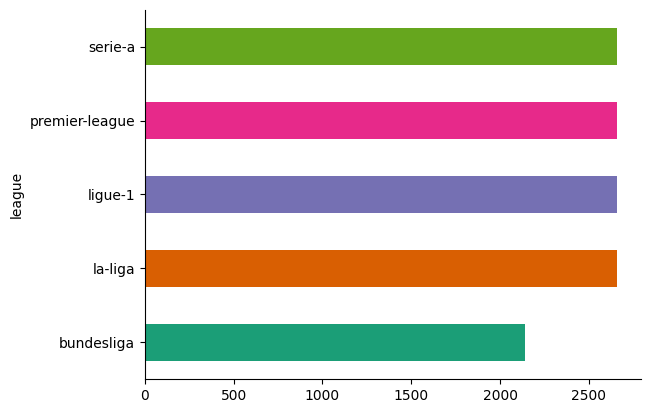

In [ ]:
train_df.groupby('league').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##### Convert Date feature to Season feature to create better distribution

In [ ]:
train_df['Season'] = pd.to_datetime(train_df['Date']).dt.year

# Convert Season to integer
train_df['Season'] = train_df['Season'].astype(int)

# Remove Date Column
train_df = train_df.drop('Date', axis=1)
train_df.head()

AC    AF   AR    AS  AST   AY       AwayTeam FTR    HC    HF   HR    HS  \
0   3.0  12.0  0.0  14.0  4.0  0.0      Stuttgart   H   6.0  12.0  0.0  13.0   
1   1.0  10.0  0.0   7.0  0.0  1.0        FC Koln   H  16.0   8.0  0.0  24.0   
2   3.0  20.0  0.0  15.0  3.0  2.0       Hannover   H   5.0  16.0  0.0  10.0   
3  10.0  28.0  0.0   9.0  3.0  2.0  Bayern Munich   D   3.0  10.0  0.0   9.0   
4   5.0  28.0  0.0  13.0  7.0  2.0     Leverkusen   D   3.0  22.0  0.0   8.0   

    HST  HTAG  HTHG   HY    HomeTeam      league  Season  
0   7.0   0.0   0.0  0.0   Wolfsburg  bundesliga    2009  
1  11.0   0.0   0.0  0.0    Dortmund  bundesliga    2009  
2   4.0   0.0   0.0  3.0      Hertha  bundesliga    2009  
3   1.0   1.0   1.0  0.0  Hoffenheim  bundesliga    2009  
4   4.0   2.0   1.0  1.0       Mainz  bundesliga    2009

##### Season-wise Data Distribution

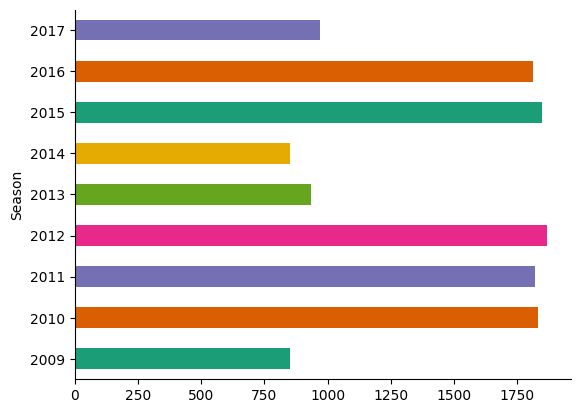

In [ ]:
train_df.groupby('Season').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##### FTR (Dependant Variable) Data Distribution

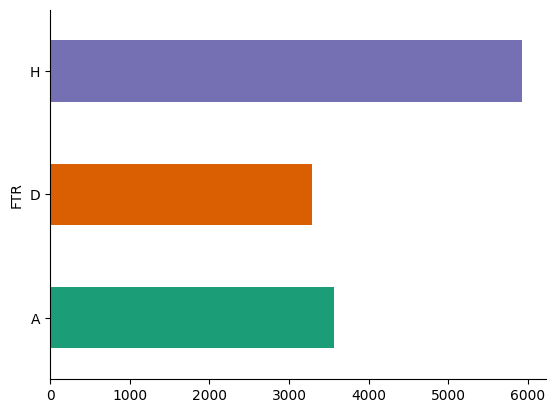

In [ ]:
train_df.groupby('FTR').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

##### FTR Data Distribution across Leagues

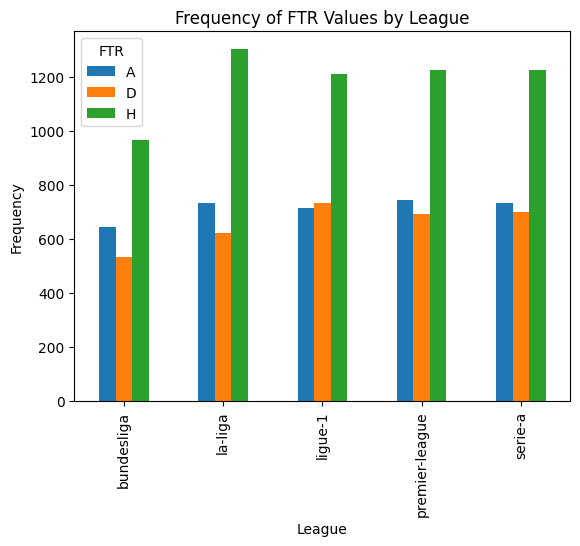

In [ ]:
train_df.groupby(['league', 'FTR']).size().unstack().plot(kind='bar')
plt.xlabel('League')
plt.ylabel('Frequency')
_ = plt.title('Frequency of FTR Values by League')

Team-wise distribution

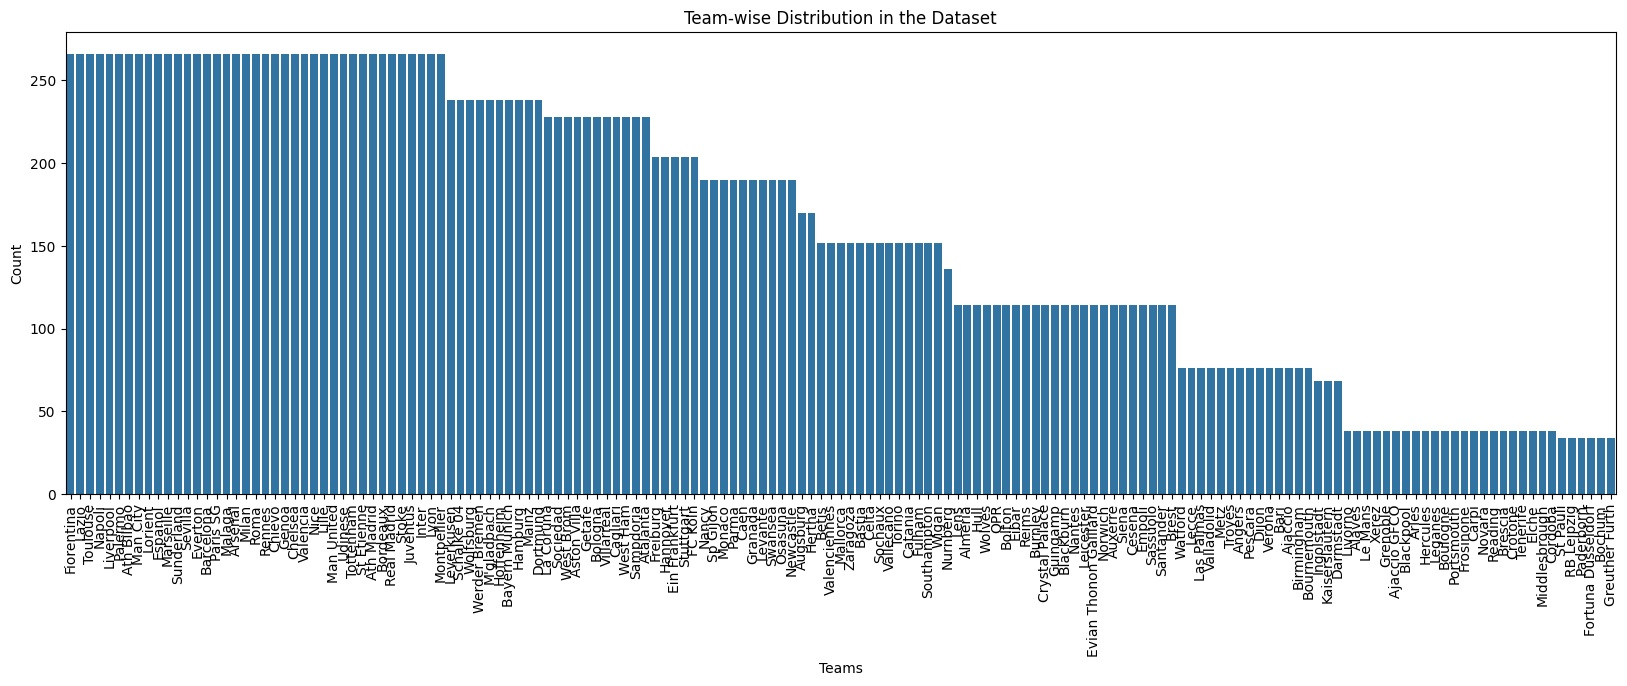

In [ ]:
# Combine home and away teams into a single set
teams = set(train_df['HomeTeam']).union(set(train_df['AwayTeam']))

# Count the number of occurrences of each team
team_counts = {}
for team in teams:
  team_counts[team] = train_df['HomeTeam'].value_counts().get(team, 0) + train_df['AwayTeam'].value_counts().get(team, 0)

# Sort the teams by their counts
sorted_teams = sorted(team_counts.items(), key=lambda x: x[1], reverse=True)

# Extract the team names and counts
team_names, team_counts = zip(*sorted_teams)

# Plot the team counts
plt.figure(figsize=(20, 6))
sns.barplot(x=team_names, y=team_counts)
plt.xticks(rotation=90)
plt.xlabel('Teams')
plt.ylabel('Count')
plt.title('Team-wise Distribution in the Dataset')
plt.show()


### Data Analyis Summary:

From the data distribution across **leagues** and **seasons**, it can be inferred that the distribution is not skewed. For the team-wise distribution, the distribution is **partially biased** for *certain teams*.

This bias can handled through **data augmentation** or **data adjustment** for building **stable** and **robust** models.

## 3. Investigate Feature Relevance

##### Convert Categorial features to Numerical

In [ ]:
train_df = convert_categorical_to_numerical(train_df)
train_df.head()


AC    AF   AR    AS  AST   AY  AwayTeam  FTR    HC    HF   HR    HS  \
0   3.0  12.0  0.0  14.0  4.0  0.0       135  2.0   6.0  12.0  0.0  13.0   
1   1.0  10.0  0.0   7.0  0.0  1.0        51  2.0  16.0   8.0  0.0  24.0   
2   3.0  20.0  0.0  15.0  3.0  2.0        64  2.0   5.0  16.0  0.0  10.0   
3  10.0  28.0  0.0   9.0  3.0  2.0        16  1.0   3.0  10.0  0.0   9.0   
4   5.0  28.0  0.0  13.0  7.0  2.0        82  1.0   3.0  22.0  0.0   8.0   

    HST  HTAG  HTHG   HY  HomeTeam  league  Season  
0   7.0   0.0   0.0  0.0       155       0    2009  
1  11.0   0.0   0.0  0.0        43       0    2009  
2   4.0   0.0   0.0  3.0        66       0    2009  
3   1.0   1.0   1.0  0.0        67       0    2009  
4   4.0   2.0   1.0  1.0        89       0    2009

##### Separate dependent and independent variables

In [ ]:
X = train_df.drop('FTR', axis=1)
y = train_df['FTR']


### 3.1. Statistical tests

##### Get f-statistic for the dataset. Get statistical significance.

In [ ]:
model = sm.OLS(y, X).fit()

print("F-statistic:", model.fvalue)
print("P-value of F-statistic:", model.f_pvalue)

print(model.summary())

F-statistic: 3078.009424608523
P-value of F-statistic: 0.0
                                 OLS Regression Results                                
Dep. Variable:                    FTR   R-squared (uncentered):                   0.813
Model:                            OLS   Adj. R-squared (uncentered):              0.812
Method:                 Least Squares   F-statistic:                              3078.
Date:                Wed, 12 Jun 2024   Prob (F-statistic):                        0.00
Time:                        16:30:11   Log-Likelihood:                         -12211.
No. Observations:               12782   AIC:                                  2.446e+04
Df Residuals:                   12764   BIC:                                  2.459e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [

##### Statistical tests: **Chi-square** test, **F-values**, and **P-Values**

In [ ]:
# Perform chi-square test
chi_scores, _ = chi2(X, y)

# Perform F-regression test
f_values, p_values = f_regression(X, y)

# Create a dataframe to store the results
results_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi-Square Score': chi_scores,
    'F-Regression Value': f_values,
    'P-Value': p_values
})

# Sort the dataframe by chi-square score
results_df = results_df.sort_values(by='Chi-Square Score', ascending=False)

# Print the dataframe
print(results_df.to_string(index=False))

 Feature  Chi-Square Score  F-Regression Value       P-Value
    HTHG       2477.540002         2782.112257  0.000000e+00
     HST       2423.091819         1625.783268  0.000000e+00
    HTAG       2418.310814         2660.124865  0.000000e+00
     AST       2401.908625         1670.412671  0.000000e+00
      AS        985.738832          524.527294 8.426280e-114
      HS        717.518720          386.860923  7.146672e-85
      HR        237.402366          233.920684  2.418473e-52
      AR        196.530377          195.344613  4.570961e-44
      HY        128.257308          136.109600  2.720251e-31
AwayTeam         78.585301            1.837798  1.752332e-01
      AF         42.776358            1.916054  1.663164e-01
      HF         41.146875           25.719373  4.003753e-07
      AY         27.940766            8.061695  4.528221e-03
      HC         27.662864            0.171903  6.784333e-01
HomeTeam          6.893190            0.158343  6.906936e-01
  league          4.2719

##### Plot the chi-square and F-Regression values

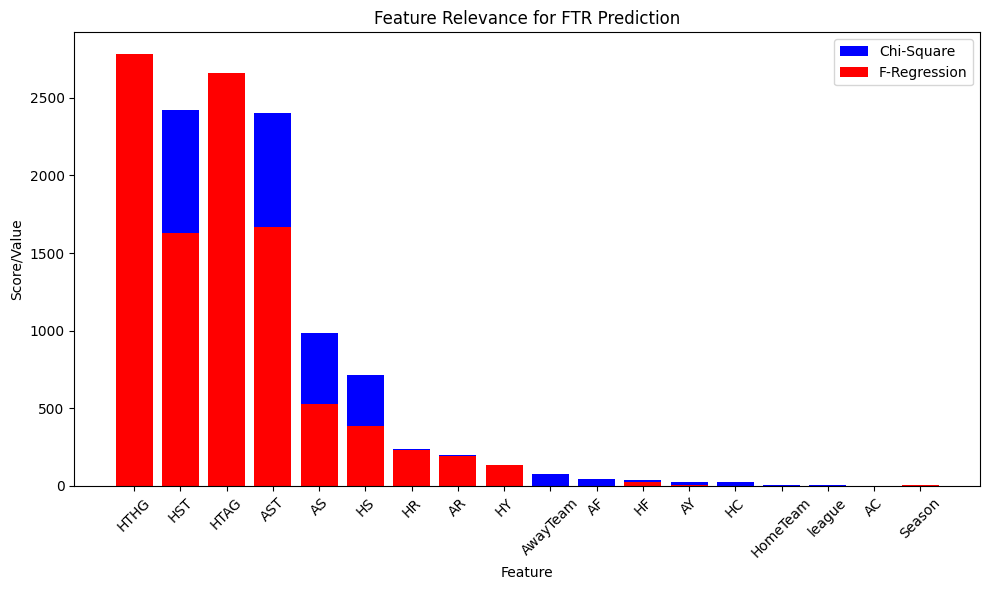

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(results_df['Feature'], results_df['Chi-Square Score'], color='blue', label='Chi-Square')
plt.bar(results_df['Feature'], results_df['F-Regression Value'], color='red', label='F-Regression')
plt.xlabel('Feature')
plt.ylabel('Score/Value')
plt.title('Feature Relevance for FTR Prediction')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Get features with high chi-square values (Taking a lower **threshold** of **100**)

In [ ]:
high_chi_square_f_regression_features = results_df[results_df['Chi-Square Score'] > 100]['Feature'].tolist()


### 3.2. Feature Collinearity Investigation

##### Get Collinearity across features using **Variance Inflation Factor** (VIF)

In [ ]:
# Calculate VIF for each feature
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Create a dataframe to store the results
vif_df = pd.DataFrame({
    'Feature': X.columns,
    'VIF': vif
})

# Sort the dataframe by VIF
vif_df = vif_df.sort_values(by='VIF', ascending=False)

# Print the dataframe
print(vif_df.to_string(index=False))


 Feature       VIF
  Season 54.215537
      HS 18.156580
      AS 15.574852
      HF 13.174551
      AF 13.172136
     HST  8.949798
     AST  7.785730
      HC  6.432954
      AC  5.379908
HomeTeam  4.427896
AwayTeam  4.417926
      AY  4.231903
      HY  3.744566
  league  3.355728
    HTHG  1.998402
    HTAG  1.741358
      AR  1.192965
      HR  1.155563


##### Plot the Collinearity Results

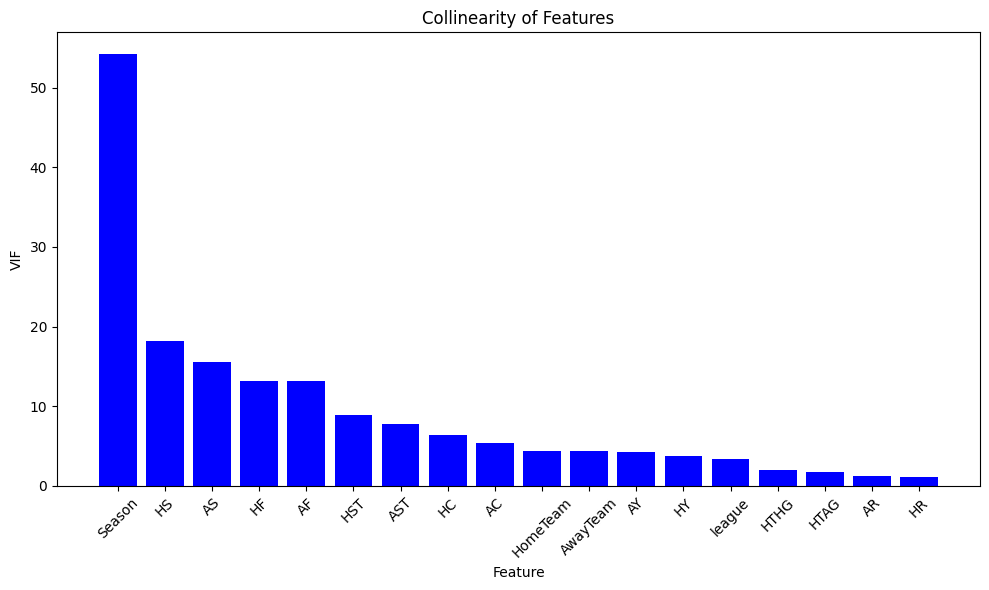

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(vif_df['Feature'], vif_df['VIF'], color='blue')
plt.xlabel('Feature')
plt.ylabel('VIF')
plt.title('Collinearity of Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Get features with low mulicollinearity (Taking standard **threshold** of **10**)

In [ ]:
low_vif_features = vif_df[vif_df['VIF'] <= 10]['Feature'].tolist()


### 3.3. Feature Correlation Investigation

##### Get Correlation Matrix for all features

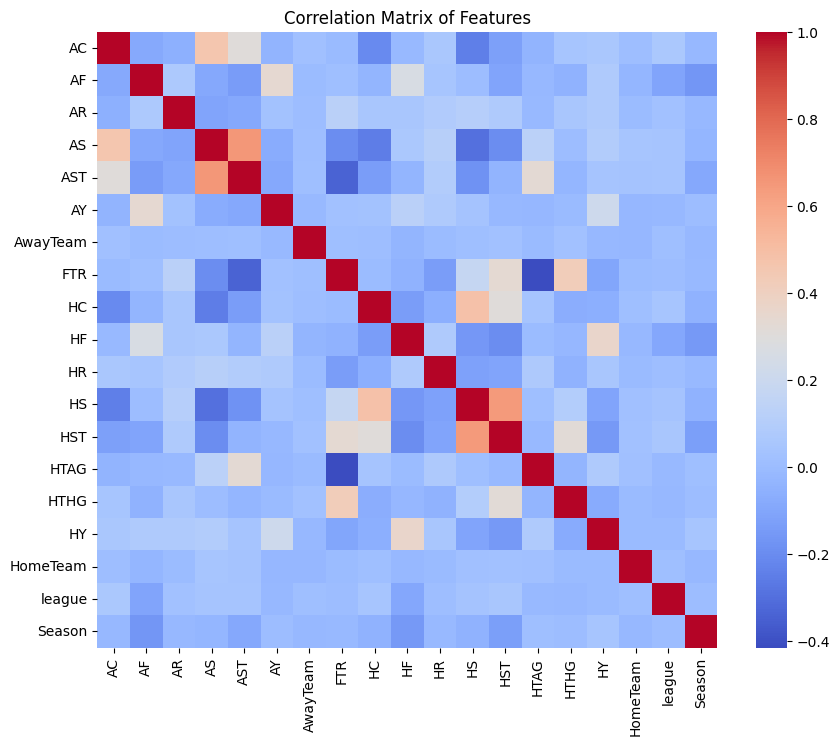

In [ ]:
# Calculate the correlation matrix
correlation_matrix = train_df.corr()

# Generate a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


##### Get Correlation of Dependant feature with Independant Features

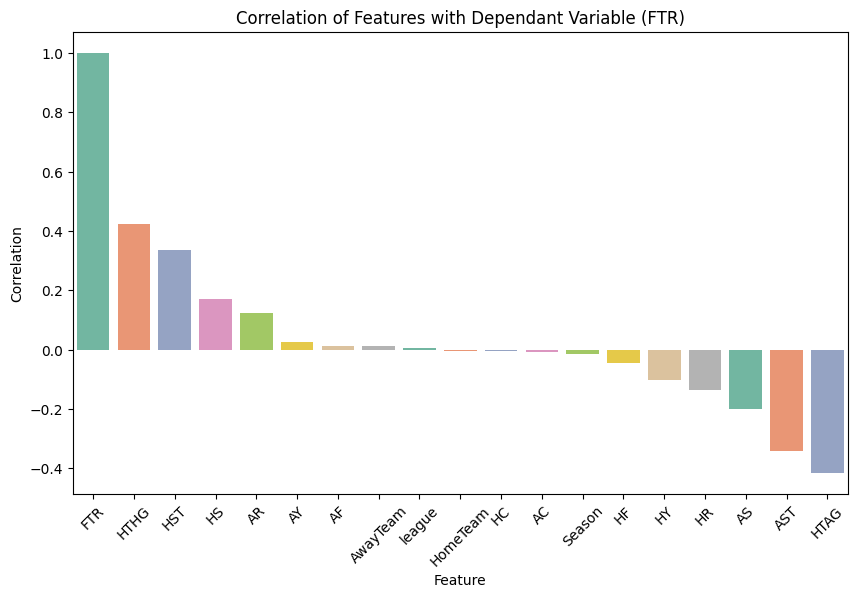

In [ ]:
# Get correlation of each feature with the dependent variable
feature_correlations = train_df.corr()['FTR'].sort_values(ascending=False)

# Create a bar chart to visualize the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_correlations.index, y=feature_correlations.values, palette='Set2')

# Add title and labels
plt.title('Correlation of Features with Dependant Variable (FTR)')
plt.xlabel('Feature')
plt.ylabel('Correlation')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.show()


##### Get features with higher correlation (Taking **threshold** of **[-0.1,0.1]**)

In [ ]:
high_correlation_features = feature_correlations[abs(feature_correlations) >= 0.1].index.tolist()


### 3.4. Final Feature Selection

In [ ]:
final_features = set(high_correlation_features + low_vif_features + high_chi_square_f_regression_features)
print("Final features:", final_features)
print("Rejected features:", set(X.columns) - final_features)


Final features: {'HomeTeam', 'HR', 'AS', 'HTAG', 'AwayTeam', 'HS', 'league', 'FTR', 'HTHG', 'AST', 'HY', 'HC', 'HST', 'AC', 'AY', 'AR'}
Rejected features: {'AF', 'Season', 'HF'}


Through **Section 2** of the code, we have carefully selected a set of features that have:
1.   High chi-square
2.   High f-statistic
3.   Low Multicollinearity
4.   High Correlation

The final list of features are:

'HC', 'HR', 'AST', 'AC', 'HY', 'AY', 'league', 'HS', 'AS', 'HTAG', 'HTHG', 'HomeTeam', 'FTR', 'AR', 'HST', 'AwayTeam'

Now, we will build prediction/ classification models using the selected features as well as all features and compare the results.


# Data Preparation

### Prepare Training Data

As the test data is for **2017** Season only, the training samples only for the 2017 Season need to be extracted.

Two separate training sets are created:

1.   **train_df_2017**: Training set with all features
2.   **train_df_2017_features**: Training set with selected features



In [ ]:
# Keep only the rows with Season value as 2017
train_df_2017 = train_df[train_df['Season'] == 2017]
train_df_2017 = train_df_2017.drop('Season', axis=1)

# Keep only the features in final_features
print(f"Number of samples before filtering by Season: {train_df.shape[0]}")
print(f"Number of samples after filtering by Season: {train_df_2017.shape[0]}")

# Keep only the features in final_features
train_df_2017_features = train_df_2017[list(final_features)]

# Print the dataframe head
train_df_2017_features.head()

Number of samples before filtering by Season: 12782
Number of samples after filtering by Season: 969


HomeTeam   HR    AS  HTAG  AwayTeam    HS  league  FTR  HTHG  AST   HY  \
1980        54  0.0  13.0   1.0        16  11.0       0  0.0   1.0  5.0  2.0   
1981        11  0.0  13.0   0.0        67   9.0       0  0.0   0.0  3.0  2.0   
1982        41  0.0  14.0   0.0        88   8.0       0  1.0   0.0  4.0  1.0   
1983       116  0.0   4.0   0.0        45  17.0       0  2.0   2.0  3.0  1.0   
1984       125  0.0  14.0   0.0        69  15.0       0  2.0   0.0  3.0  1.0   

       HC  HST    AC   AY   AR  
1980  1.0  3.0  11.0  2.0  0.0  
1981  4.0  2.0   4.0  4.0  0.0  
1982  4.0  2.0   6.0  1.0  0.0  
1983  3.0  7.0   3.0  2.0  1.0  
1984  7.0  5.0   3.0  0.0  0.0

### Prepare Test Data

Pre-process the test data with the same pre-process steps used on the training data

Further the columns **Date**, **index**, and **Referee** are dropped as they are not there in the training data

In [ ]:
# Read test data from csv
test_df = pd.read_csv(test_path)

# Remove samples with null values for 'Away Team' and 'Home Team'
test_df = test_df.dropna(subset=['AwayTeam', 'HomeTeam'])

# Replace null values with an optimal value for each column
numeric_columns = test_df.select_dtypes(include=['float', 'int']).columns
for column in numeric_columns:
    if test_df[column].isnull().any():
        test_df[column] = test_df[column].fillna(test_df[column].mean())

categorical_columns = test_df.select_dtypes(include=['object']).columns
for column in categorical_columns:
    if test_df[column].isnull().any():
        test_df[column] = test_df[column].fillna(test_df[column].mode()[0])


# Remove Date, and Referee Columns
test_df = test_df.drop(['Date', 'index', 'Referee'], axis=1)

# Convert categorical data to numerical data
test_df = convert_categorical_to_numerical(test_df)

test_df.head()


AC  AF  AR  AS  AST  AY  AwayTeam  HC  HF  HR  HS  HST  HTAG  HTHG  HY  \
0   5  17   0  19    4   2        50   4  13   0  13    8     0     2   1   
1   7  16   0  13    1   3         7   3  18   0  11    5     0     1   4   
2   1  12   0   9    2   1        83   5  18   0  10    3     0     0   2   
3   4  15   0  11    2   3        94   6  17   0  14    3     0     0   1   
4   1  14   0   6    2   5        38  13  18   0  14    6     0     0   3   

   HomeTeam  league  
0         9       0  
1        37       0  
2        39       0  
3        40       0  
4        55       0

##### Create test set with selected features

In [ ]:
# Create a dataframe for test set with only relevant features
test_features = [feature for feature in final_features if feature != 'FTR']
test_df_features = test_df[list(test_features)]

# Print the resultant dataframe head
test_df_features.head()


HomeTeam  HR  AS  HTAG  AwayTeam  HS  league  HTHG  AST  HY  HC  HST  AC  \
0         9   0  19     0        50  13       0     2    4   1   4    8   5   
1        37   0  13     0         7  11       0     1    1   4   3    5   7   
2        39   0   9     0        83  10       0     0    2   2   5    3   1   
3        40   0  11     0        94  14       0     0    2   1   6    3   4   
4        55   0   6     0        38  14       0     0    2   3  13    6   1   

   AY  AR  
0   2   0  
1   3   0  
2   1   0  
3   3   0  
4   5   0

Split training data (all features and selected features) for training and validation

Training:Validation Split is **80:20**

In [ ]:
# Split dependant and independant features
X_all = train_df_2017.drop('FTR', axis=1)
y_all = train_df_2017['FTR']
X_ftr = train_df_2017_features.drop('FTR', axis=1)
y_ftr = train_df_2017_features['FTR']

# Split complete data for 2017
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=0)

# Split data and keep only relevant features
X_train_features, X_val_features, y_train_features, y_val_features = train_test_split(X_ftr, y_ftr, test_size=0.2, random_state=0)

# Print the shapes of the split data
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

print(f"X_train_features shape: {X_train_features.shape}")
print(f"X_val_features shape: {X_val_features.shape}")
print(f"y_train_features shape: {y_train_features.shape}")
print(f"y_val_features shape: {y_val_features.shape}")


X_train shape: (775, 17)
X_val shape: (194, 17)
y_train shape: (775,)
y_val shape: (194,)
X_train_features shape: (775, 15)
X_val_features shape: (194, 15)
y_train_features shape: (775,)
y_val_features shape: (194,)


# Utility functions for training and testing

In [ ]:
# Function to create path to save trained models
def create_model_path(model_path):
  """
  Creates a directory for saving models if it doesn't exist.

  Args:
    model_path: The path to the directory.
  """
  if not path.exists(model_path):
    print(f"Model Directory '{model_path}' does not exist. Creating Model Directory '{model_path}'")
    makedirs(model_path)

# Function to convert Numerical data to Categorical (for FTR feature only)
def convert_numerical_to_categorical(train_df):
  """
  Converts the FTR column from numerical to categorical.
  """
  df = train_df.copy()
  df['FTR'] = df['FTR'].astype('category')
  # Define mapping dictionary
  mapping = {
    2.0: 'H',
    1.0: 'D',
    0.0: 'A'
  }
  # Apply mapping to FTR column
  df['FTR'] = df['FTR'].map(mapping)
  return df


# Training and Validation

### Training the model using the following ML classification algorithms:

1.   Logistic Regression
2.   Support Vector Machine (SVM)
3.   Bagging - Random FOrest
4.   Boosting - eXtreme Gradient Boosting (XGBoost)

**Grid Search** is also used to find the best set of hyper-paramaters for each model





In [ ]:
# Function to create models and train them
def create_and_train_models(X_train, y_train, ftr):
  '''
  Create and train the models.
  Use Grid Search to estimate best parameters

  Args:
    X_train: The training features.
    y_train: The training labels.
    ftr: Whether to use selected features or all features.
  '''

  # Define models
  models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
  }

  # Define grid search parameters for each model
  param_grids = {
    "Logistic Regression": {"C": [0.01, 0.1, 1, 10], "penalty": ["l1", "l2"]},
    "SVM": {"C": [0.01, 0.1, 1, 10], "kernel": ["linear", "poly", "rbf"]},
    "Random Forest": {"n_estimators": [10, 50, 100], "max_depth": [None, 5, 10]},
    "XGBoost": {"learning_rate": [0.01, 0.1, 0.2], "max_depth": [None, 5, 10]}
  }

  # Train and evaluate each model
  for name, model in models.items():
    print(f"Training model: {name}")
    grid_search = GridSearchCV(model, param_grids[name], cv=5)
    grid_search.fit(X_train, y_train)

    # Print best parameters and score
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")

    # Train the model with best parameters
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Save the models
    if ftr:
      # Path for models with selected features
      model_path = "ftr_models"
    else:
      # Path for models with all features
      model_path = "models"

    create_model_path(model_path)
    print(f"Saving model to {model_path}/{name}.joblib")
    print()
    dump(best_model, f"{model_path}/{name}.joblib")


#### Train models with all features

In [ ]:
create_and_train_models(X_train, y_train, False)


Training model: Logistic Regression
Best parameters: {'C': 10, 'penalty': 'l2'}
Best score: 0.6799999999999999
Saving model to models/Logistic Regression.joblib

Training model: SVM
Best parameters: {'C': 1, 'kernel': 'linear'}
Best score: 0.687741935483871
Saving model to models/SVM.joblib

Training model: Random Forest
Best parameters: {'max_depth': 10, 'n_estimators': 100}
Best score: 0.6761290322580645
Saving model to models/Random Forest.joblib

Training model: XGBoost
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
Best score: 0.6619354838709677
Saving model to models/XGBoost.joblib



#### Train models with selected features

In [ ]:
create_and_train_models(X_train_features, y_train_features, True)


Training model: Logistic Regression
Best parameters: {'C': 0.1, 'penalty': 'l2'}
Best score: 0.6864516129032258
Saving model to ftr_models/Logistic Regression.joblib

Training model: SVM
Best parameters: {'C': 10, 'kernel': 'linear'}
Best score: 0.687741935483871
Saving model to ftr_models/SVM.joblib

Training model: Random Forest
Best parameters: {'max_depth': 5, 'n_estimators': 100}
Best score: 0.6774193548387097
Saving model to ftr_models/Random Forest.joblib

Training model: XGBoost
Best parameters: {'learning_rate': 0.1, 'max_depth': 5}
Best score: 0.6606451612903226
Saving model to ftr_models/XGBoost.joblib



### Evaluate Model Performance on Validation Set

In [ ]:
# Function to evaluate model performance on validation set
def evaluate_models(X_val, y_val, model_path):
  '''
  Evaluate the performance of each model and generate the
  Accuracy Score, Confusion Matrix, and Classification Report.

  Args:
    X_val: The test features.
    y_val: The test labels.
    model_path: The path where the models are saved.
  '''
  models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
  }

  for name, model in models.items():
    # Load the model
    model = load(f"{model_path}/{name}.joblib")

    # Make predictions
    y_pred = model.predict(X_val)

    # Print model name
    print(f"Model: {name}")

    # Print confusion matrix
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

    # Print accuracy score
    print("Accuracy Score:", accuracy_score(y_val, y_pred))

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_val, y_pred))

    # Print a new line
    print()


##### Evaluate models with all features on validation set

In [ ]:
evaluate_models(X_val, y_val, 'models')


Model: Logistic Regression
Confusion Matrix:
[[50  9  6]
 [11 10 14]
 [10  6 78]]
Accuracy Score: 0.711340206185567
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.77      0.74        65
         1.0       0.40      0.29      0.33        35
         2.0       0.80      0.83      0.81        94

    accuracy                           0.71       194
   macro avg       0.63      0.63      0.63       194
weighted avg       0.69      0.71      0.70       194


Model: SVM
Confusion Matrix:
[[54  6  5]
 [ 9 11 15]
 [ 8  7 79]]
Accuracy Score: 0.7422680412371134
Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.83      0.79        65
         1.0       0.46      0.31      0.37        35
         2.0       0.80      0.84      0.82        94

    accuracy                           0.74       194
   macro avg       0.67      0.66      0.66       194
weighted avg       0.72      

##### Evaluate models with selected features on validation set

In [ ]:
evaluate_models(X_val_features, y_val_features, 'ftr_models')


Model: Logistic Regression
Confusion Matrix:
[[50  8  7]
 [11  9 15]
 [ 9  7 78]]
Accuracy Score: 0.7061855670103093
Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.77      0.74        65
         1.0       0.38      0.26      0.31        35
         2.0       0.78      0.83      0.80        94

    accuracy                           0.71       194
   macro avg       0.62      0.62      0.62       194
weighted avg       0.68      0.71      0.69       194


Model: SVM
Confusion Matrix:
[[51  9  5]
 [11  9 15]
 [ 8  6 80]]
Accuracy Score: 0.7216494845360825
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.78      0.76        65
         1.0       0.38      0.26      0.31        35
         2.0       0.80      0.85      0.82        94

    accuracy                           0.72       194
   macro avg       0.63      0.63      0.63       194
weighted avg       0.70     

**Best Models:** From the *f1-scores* of the models it can be seen:

1.   For **Random forest** and **XGB** models perform better with **selected** features
2.   For **SVM model** and **Logistic Regression** perform better with **all** features

The **SVM** model with **all** features has an accuracy of **74%**, which is the **highest** among the candidate models.


# Prediction on Test Data

In [ ]:
# prompt: Write a function to predict on the test data test_df_features using the Random Forest and XGBoost models with selected features. Convert the predicted result to categorical data using the function convert_numerical_to_categorical. Then save the predicted results in the same file under a folder 'test_results'.

def predict_and_save(X_test, model_path, filename):
  """
  Predict on the test data and save the results.

  Args:
    X_test: The test features.
    model_path: The path where the models are saved.
    filename: The filename for saving the results.
  """
  # Load the models
  log_reg_model = load(f"{model_path}/Logistic Regression.joblib")
  svm_model = load(f"{model_path}/SVM.joblib")
  rf_model = load(f"{model_path}/Random Forest.joblib")
  xgb_model = load(f"{model_path}/XGBoost.joblib")

  # Make predictions
  log_reg_predictions = log_reg_model.predict(X_test)
  svm_predictions = svm_model.predict(X_test)
  rf_predictions = rf_model.predict(X_test)
  xgb_predictions = xgb_model.predict(X_test)

  # Combine predictions
  predictions = pd.DataFrame({
    "Logistic Regression": log_reg_predictions,
    "SVM" : svm_predictions,
    "Random Forest": rf_predictions,
    "XGBoost": xgb_predictions
  })

  # Create directory to store results
  create_model_path(model_path)

  # Convert to categorical data

  # Define the mapping dictionary
  mapping = {
      2.0: 'H',
      1.0: 'D',
      0.0: 'A'
  }

  # Apply the mapping to each column in the dataframe
  for column in predictions.columns:
      predictions[column] = predictions[column].map(mapping)

  # Save the results
  predictions.to_csv(filename)


In [ ]:
# Predict and save results for selected features
predict_and_save(test_df, 'models', 'test_results/predictions_all_features.csv')
predict_and_save(test_df_features, 'ftr_models', 'test_results/predictions_selected_features.csv')

# Appendix

### Model Explainability

Through model explainability we can achieve the following:
1. Understanding which features are more important for both correct and incorrect predictions - This can help in **selecting** a better **feature set**
2. This would inherently add to the **robustness** of the model
3. It would also improve the **trust** for the system as a whole for the user

In the following piece of code, Local Interpretable Model-agnostic Explanations (**LIME**) is used to get the interpretability of the trained model over selected samples.



Import LIME package for explanability

In [ ]:
# !pip install lime
import lime
import lime.lime_tabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=811a861c5a30a8686d8cd2cd29d97151720e03a9976f90d3cdbc2edb6db4237a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


Function for explaining Random Forest and XGB models with LIME

In [ ]:
def explain_models(train_df, X_train, sample_id):
  """
  Explain the Random Forest, and XGBoost models using LIME.

  Args:
    train_df: The training dataset.
    X_train: The training features.
  """

  # Convert FTR labels to categorical
  train_df_cat = convert_numerical_to_categorical(train_df)

  # Load models
  rf_model = load("models/Random Forest.joblib")
  xgb_model = load("models/XGBoost.joblib")

  # Define explainer for Random Forest model
  rf_explainer = lime.lime_tabular.LimeTabularExplainer(
      training_data=X_train.values,
      feature_names=X_train.columns,
      class_names=train_df_cat['FTR'].unique(),
      mode='classification'
  )
  # Define explainer for XGB model
  xgb_explainer = lime.lime_tabular.LimeTabularExplainer(
      training_data=X_train.values,
      feature_names=X_train.columns,
      class_names=train_df_cat['FTR'].unique(),
      mode='classification'
  )

  # Explain each model on a sample instance
  sample_instance = X_train.iloc[sample_id]

  rf_explanation = rf_explainer.explain_instance(
      sample_instance, rf_model.predict_proba
  )
  xgb_explanation = xgb_explainer.explain_instance(
      sample_instance, xgb_model.predict_proba
  )

  # Print the explanations
  print("Random Forest Explanation for sample " + str(sample_id) + ":")
  print(rf_explanation.as_list())
  print()
  print("XGBoost Explanation for sample " + str(sample_id) + ":")
  print(xgb_explanation.as_list())
  print()

  # Show explanations in notebook
  print("Random Forest Explanation:")
  rf_explanation.show_in_notebook(show_table=True)
  print()
  print("XGBoost Explanation:")
  rf_explanation.show_in_notebook(show_table=True)


Get explanations for a sample

In [ ]:
sample_id = 15 # Sample for explanation

# Print Groundtruth label
mapping = {
    2.0: 'H',
    1.0: 'D',
    0.0: 'A'
  }
y_train_cat = y_train.apply(lambda x: mapping[x])
print(f'Groundtruth Label of Sample: {y_train_cat.iloc[sample_id]}')
print()

# Get and print explanations
explain_models(train_df, X_train, sample_id)

Groundtruth Label of Sample: D

Random Forest Explanation for sample 15:
[('HTHG <= 0.00', 0.07536330529469122), ('HST <= 3.00', 0.07501585394699709), ('HR <= 0.00', -0.0678961545375006), ('2.00 < AST <= 4.00', 0.012651449820315207), ('HS <= 10.00', 0.010951377173520769), ('AY <= 1.00', 0.010946285406386771), ('HomeTeam <= 42.00', -0.010910266503380102), ('league <= 1.00', 0.009599755325789404), ('AR <= 0.00', -0.008687894044585264), ('3.00 < HC <= 5.00', -0.007459652466890364)]

XGBoost Explanation for sample 15:
[('HST <= 3.00', 0.1238553932719743), ('HTHG <= 0.00', 0.10968284458196698), ('HR <= 0.00', -0.046312824984947445), ('HS <= 10.00', -0.041526575024040835), ('AY <= 1.00', 0.02596290335595696), ('79.00 < AwayTeam <= 113.00', 0.02543527320377334), ('11.00 < AS <= 14.00', -0.021927304949173006), ('10.00 < HF <= 12.00', 0.015186467724100641), ('3.00 < HC <= 5.00', 0.013609968863837602), ('AR <= 0.00', -0.010910979915778586)]

Random Forest Explanation:



XGBoost Explanation:


### Data Augmentation and Incremental Learning

One of the best methods to improve model **robustness** is by adding more data.

When new data is added, it has been a general practise to re-train the models from scratch. This can lead to loss of time and investment. A better way to add new data is through **Incremental Learning**. This also is a valuable tool especially while **scaling** ML models.

The function below demonstrates how new data can be added to the existing models through Incremental Learning, using the **Dask-ML** library.

This is just a sample code to establish the point.


In [ ]:
# Update the classification models with new data, through Incremental Learning in Dask-ML

import dask.dataframe as dd
from dask_ml.model_selection import Incremental

def update_models_incrementally(models, new_data):
    """
    Update the classification models with new data using incremental learning in Dask-ML.

    Args:
        models: A dictionary containing the trained classification models.
        new_data: A Dask DataFrame containing the new data.

    Returns:
        A dictionary containing the updated models.
    """

    # Prepare the new data
    X_new = new_data.drop('FTR', axis=1)
    y_new = new_data['FTR']

    # Define the incremental learner
    learner = Incremental(n_classes=3)

    # Update each model
    for name, model in models.items():
        # Create an Incremental model
        incremental_model = learner.create_model(model)

        # Fit the incremental model on the new data
        incremental_model.fit(X_new, y_new)

        # Update the original model
        models[name] = incremental_model.model

    return models
